# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

## Motivation and Goal:

### General:

* Recurrent Neural Nets (RNNs) model a conditional distribution over tokens:

$$ 
\newcommand{\given}{\,\big|\,}
p\left(y_1, y_2, \ldots, y_T\right) = p\left(y_1\right)\prod_{t=2}^T p\left(y_t\given y_1\,,\dots\,, y_{t−1}\right)\,
$$

* Maximum Likelihood (ML) training of RNNs is currently implemented using so-called "Teacher Forcing" (TF). Namely, we feed the ground-truth tokens $\mathbf{y}$ in the model to be conditioned on when generating the predicted outputs to be evaluated. If we don't do so, the sequence over which we condition on diverges from sequences seen during training and the errors can amplify exponentially

* In some domains the sequences available at training time are shorter than the sequences that we want to generate at test time. Also, for problems in which the goal is prediction of values that are farther in time, TF is an approximation

* When testing/performing inference, we don't feed the input sequence in the network, so at each time step the output is generated conditioning on the previous generated outputs (with the exception of the first token, which is usually some starting sequence identifier). This is inconsistent! 

* We refer to the mechanism opposed to TF as "Free Running". There are multiple variants of this approach used during inference, although usually only sampling is used during training:

    * **Sampling**: at each time step we use a sample $\hat{y}_t$ from $p\left(y_t\given \hat{y}_1\,,\dots\,, \hat{y}_{t−1}\right)$ and we add it to the conditioning set for $\hat{y}_{t+1}$
    <br>
    * **Greedy**: at each time step we select $\hat{y}_t = \arg\max_y p\left(y_t\given \hat{y}_1\,,\dots\,, \hat{y}_{t−1}\right)$
    <br>
    * **Beam search**: at each time step, we maintain a set of the $m$ "most promising" sentences. We expand each of them and we sort the results in term of joint probability. Finally we truncate them to retain those with higher probability

### Specific to our problem (VAEs for text modelling):

When generating a sentence $\mathbf{y}$ we condition on a sample of the latent variable $\mathbf{z}$, namely:

$$\log p\left(\mathbf{y}\given\mathbf{z};\theta\right) = \sum_{t=1}^T\log p\left(y_t\given y_1\,,\ldots\,,y_{t-1}, \mathbf{z};\theta\right)\,,
$$

where we have:

$$
\log p\left(y_t\given y_1\,,\ldots\,,y_{t-1}, \mathbf{z};\theta\right) = \log p\left(y_t\given h_t\right)\,
$$

and:

$$
h_t = 
\begin{cases} 
    f\left(\mathbf{z};\theta\right) & \text{if } t=1\\ 
    f\left(h_{t-1}, y_{t-1}; \theta\right) & \text{otherwise}\\
\end{cases}\,.
$$

The generation parameters $\theta$ are optimised using ML training over mini-batches:

$$
\theta^* = \arg\max_\theta \sum_{n=1}^N \log p\left(\mathbf{y}^n\given \mathbf{z}^n;\theta\right)\,.
$$

* Currently we use teacher forcing to train the langauge model. This makes the entire model too powerful to meaningfully use latents - needs for KL annealing and word drop procedures:

    * KL annealing is implemented by gradually turning on the KL term in the ELBO during training (tackled by AutoGen training)
    * Word drop is implemented by randomly dropping randomly and replacing some fraction of the conditioned-on word tokens with the generic unknown word token `<UNK>`

* We consider the use of these procedures an artifact that invalidates the performance of the model itself

Teacher-forcing affects the problem of Natural Language generation in more than one way: 

1. Textual data is naturally sparse. As soon as the conditional generation implemented using sampling mode deviates from a known sequence, the entire generation diverges

2. For the same reason, when generating a text using TF, the latents are barely used (conditioning on the latents is barely helpful when the next word is well-specified by the sequence of the preceeding ones)

We remark that image generation models (e.g. PixelRNN) are not reported to use this procedure while training (plus, they can use latents pretty well). We argue that this is due to the use of only local information in the generative model (so that the latents can contribute to capturing the global context)

## State of the Art:

### Teacher Forcing (Williams and Zipser, 1989)

What we have described above, with all the positive and negative aspects.

### Curriculum Learning (Bengio et al., 2015)

The training process is re-designed in order to **gradually** force the model to deal with its own mistakes, as it would have to during inference.

During training, at every time step $t$ we flip a biased coin. With probability $\epsilon_t$ we use a token from the ground-truth $\mathbf{y}$ (teacher forcing) and with probability $1 - \epsilon_t$ we use the previously generated token $\hat{y}_{t-1}$ (sampling mode).

<figure>
    <img src="./scheduled-sampling.png" width="500" />
</figure>    

Two extremes:
1. $\epsilon_t = 1\,\forall t$ is the teacher forcing approach
2. $\epsilon_t = 0\,\forall t$ is the sampling mode approach

Idea: annealing $\epsilon_t$ over time steps (**scheduled sampling**). Three options:

1. Linear decay: $\epsilon_t = \max\left(\epsilon, k − c\cdot t\right)$, with $\epsilon \in (0,1)$, $k$ and $c$ parameters
2. Exponential decay: $\epsilon_t = k^t$, with $k < 1$ parameter 
3. Inverse sigmoid decay: $\epsilon_t = \dfrac{k}{k + \exp\left(\dfrac{t}{k}\right)}$, with $k\geq 1$ parameter

No error is back-propagated when samples $\hat{y}_{t}$ are used for conditional generation. Sampling the previous token leads to a stochastic node in the computational graph for which the gradient cannot be computed directly. Will come to this point later.

Without back-propagating the gradient through the samples the results of training are likely to be strongly degraded (and actually they are).

### Professor Forcing (Goyal et al., 2016)

**Adversarial approach**: a pair of twin RNNs (with shared parameters $\theta_g$) output sentences using teacher forcing and sampling mode respectively. A **classifier** discriminates if the hidden states are generated by the first network or by the second one.

<figure>
    <img src="./professor-forcing.jpg" width="600" />
</figure>

The classifier/discriminator is a Bidirectional RNN with parameters $\theta_d$ trained to maximise the likelihood of
correctly classifying a behaviour sequence (chosen hidden states and output values):

$$
\min_{\theta_d}\mathbb{E}_{(x, y)\sim \text{data}}\left[− \log D\left(B\left(x, y; \theta_g\right); \theta_d\right)\right] + \mathbb{E}_{x\sim\text{data}, y\sim p_{\theta_g}\left(y| x\right)}
\left[− \log \left(1 − D\left( B \left(x, y; \theta_g\right); \theta_d\right)\right)\right]\,,
$$

where $D\left(\mathbf{s}\right)$ is the discriminator function (i.e. the probability that the sequence $\mathbf{s}$ is produced in teacher forcing mode) and $B$ is the behaviour sequence generator. The first term corresponds to the TF case while the second term corresponds to the sampling mode. Please notice that in our case, since we do not have different inputs/outputs, in the first term we simply have $x = y$.

The two hidden layers of the discriminator (forward and backward RNN) are then concatenated at each time step and passed through a MLP, which outputs the discriminator function $D\left(\cdot\right)$.

The generator is an RNN trained to maximise the likelihood of the data and contextually fool the discriminator:

$$
\min_{\theta_g}\mathbb{E}_{(x,y)\sim\text{data}}\left[− \log p_{\theta_g}\left(y\given x\right)\right]
+
 \mathbb{E}_{x\sim\text{data}, y\sim p_{\theta_g}\left(y|x\right)}
\left[− \log D\left(B\left(x, y; \theta_g\right); \theta_d\right)\right]\,,
$$

where the first term is the negative log-likelihood (NLL) and the second term aims at maximising the probability of the sampling mode behaviour such that it matches the teacher force behaviour.

Eventually we can ask the teacher force behavior to be indistinguishable from the sampling mode behavior:

$$
\mathbb{E}_{(x,y)\sim\text{data}}\left[− \log\left(1 − D\left(B\left(x, y; \theta_g\right); \theta_d\right)\right)\right].
$$

Practically, this is achieved with a variant of stochastic gradient descent with minibatches formed by combining $N$ sequences obtained in teacher forcing mode and $N$ sequences obtained in sampling mode.

### Categorical Reparametrisation with Gumbel-Softmax (Jang et al., 2017)

In the Curriculum Learning approach, there is no gradient back-propagated when the previous samples are used for conditional generation in the RNN (due to the stochasticity of the operation). This approach badly affect learning performance. We can overcome this problem by using a reparametrisation of the categorical distribution (equivalent concept of the Gaussian reparametrisation trick in VAEs).

The Gumbel-Max trick (Gumbel, 1954) provides a way to draw samples $z$ from a categorical distribution with class probabilities $\pi$:

$$z = \text{one hot}\left(\arg \max_i\left[g_i + \log \pi_i\right]\right)\,,$$

where $g_1,\,\ldots\,,g_k$ are i.i.d samples drawn from the $\text{Gumbel}(0, 1)$ distribution. 

$$
g_1,\,\ldots\,,g_k \sim \exp\left\{-\left(g + \exp\{-g\}\right)\right\}\,.
$$

Approximate samples $y$ are obtained by replacing the non-differentiable $\arg \max$ with a softmax function, returning:

$$y_i = \dfrac{\exp\left(g_i + \log \pi_i\right)/\tau}{\sum_{j=1}^k \exp\left(g_j + \log \pi_j\right)/\tau}\,\forall i=1,\,\ldots,\,k\,.$$

$\tau$ is a temperature parameter. For learning, there is a tradeoff between small temperatures, where samples are close to one-hot but the variance of the gradients is large, and large temperatures, where samples are smooth but the variance of the gradients is small [cit].

<img src="./gumbel-softmax.png" width="600" />

The Gumbel-Softmax distribution is smooth for $\tau > 0$, and therefore has a well-defined gradient with respect to $\pi$. Thus, by replacing categorical samples with Gumbel-Softmax samples we can use backpropagation to compute the gradients with respect to the sampled words in an RNN trained without teacher-forcing.

Notice that in the derivation of the samples $y_i$ we have used a continuous softmax function. If we want samples to be discrete (like in our case) we still apply the $\arg \max$ operator to $y_i$, but the gradient is approximated as: $$\nabla_\theta z \approx \nabla_\theta y\,.$$ In this case the estimator is known as Straight Trought (ST) Gumbel-Softmax.

## Considerations and Next Steps:

We argue that TF, despite the help provided during the training phase, is not a useful way to train a generative model for text if our objective is to incorporate meaningful latents. On the other side, pure training without TF leads to instability and low performance (experiments are in progress).

Removing the TF procedure has been already found useful for other problems, and different solution has been proposed to solve the problem. A good initial result would be to remove the need for the word drop procedure in text-VAE. We also expect the role of the latents to change.

The immediate next steps are:

Short term:
* Run experiment without TF and without any alternative algorithm
* Run experiment using sampling mode on top of the results learned using TF (hard version of CL that completely switches off TF after a fixed iteration)
* Run experiment using alternative algorithms (in particular CL and ST Gumbel-Softmax are easier to implement) 

Long term:
* Re-formulate the problem in a way that sparsness of the data + training do not degrade the role of the latents

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Flatten

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

In [2]:
sp500 = pd.read_csv('/Users/robertofiermonte/Downloads/all_stocks_5yr.csv')
aapl = sp500[sp500['Name'] == 'AAPL']['open'].reset_index(drop=True)

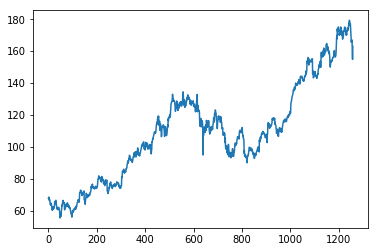

In [3]:
tf.reset_default_graph()
n_points = aapl.shape[0]
look_forward = 10

nested = pd.Series.from_array([aapl[idx:idx+look_forward + 1].reset_index(drop=True) for idx, val in aapl.items()])
nested = nested[:n_points - look_forward]

X = np.array(nested.apply(lambda x: x[:-1])) 
X = np.reshape(X, [X.shape[0], X.shape[1], 1])
y = np.array(nested.apply(lambda x: x[10]))

plt.plot(aapl)

In [4]:
baseline = Sequential()
baseline.add(SimpleRNN(100, return_sequences=False, input_shape=(look_forward, 1)))
baseline.add(Dense(1))
baseline.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
baseline.fit(X, y, epochs=50, batch_size=100, verbose=0)

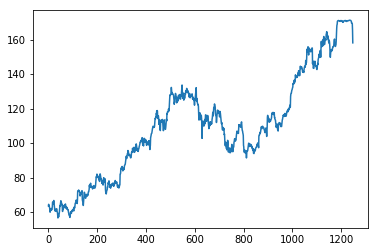

In [16]:
y_hat = baseline.predict(X)
plt.plot(y_hat)

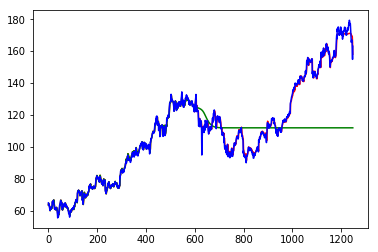

In [17]:
aapl_copy = aapl.copy()
y_sampl = np.array([])
y_sampl_ar = np.array([])

for idx in range(X.shape[0]):
    pred = baseline.predict(aapl[idx:idx + look_forward].values.reshape([1, look_forward, 1]))
    y_sampl = np.append(y_sampl, pred)
    pred_ar = baseline.predict(aapl_copy[idx:idx + look_forward].values.reshape([1, look_forward, 1]))
    y_sampl_ar = np.append(y_sampl_ar, pred_ar)
    if idx > 590:
        aapl_copy[idx + look_forward] = pred_ar

plt.plot(y_sampl, 'r-', y_sampl_ar, 'g', y, 'b')

In [162]:
def make_posterior(data):
#     var = tf.Variable(tf.ones(data.shape[1]), name='posterior_var')
#     return tfd.MultivariateNormalDiag(data, tf.nn.softplus(var))
    mean = tf.layers.dense(data, 1, n)
    stddev = tf.nn.softplus(tf.get_variable('posterior_std'))
    return tfd.Independent(tfd.Normal(mean, stddev), 1)

def make_generative(latents):
    mean = tf.layers.dense(latents, 1)
    stddev = tf.nn.softplus(tf.get_variable('generative_std'))  
#     var = tf.Variable(tf.ones(latents.shape[1]), name='generative_var')
#     return tfd.MultivariateNormalDiag(latents, tf.nn.softplus(var))
    return tfd.Independent(tfd.Normal(mean, stddev), 1)

def make_transitional(latents):
#     out, hid = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUBlockCell(100), latents, dtype=tf.float32)
#     m = tf.Variable(tf.random_normal([100, 1]), name='transitional_mean')
#     v = tf.Variable(tf.random_normal([100, 1]), name='transitional_var')
    
#     return tfd.MultivariateNormalDiag(tf.squeeze(tf.tensordot(out, m, axes=1), -1), 
#                                      tf.squeeze(tf.nn.softplus(tf.tensordot(out, v, axes=1))), -1)

    _, hid = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUBlockCell(100), latents[:, -1], dtype=tf.float32)
    mean = tf.layers.dense(hid, 1)
    stddev = tf.layers.dense(hid, 1, tf.nn.softplus)
    return tfd.Independent(tfd.Normal(mean, stddev), 1)
    
tf.reset_default_graph()

n_samples = 10

x_ = tf.placeholder(tf.float32, [None, 10])
y_ = tf.placeholder(tf.float32, [None, 1])

posterior = make_posterior(x_)

latents = posterior.sample((n_samples))

p_generative = make_generative(latents).log_prob(x_)
p_transition = make_transitional(tf.reshape(latents, [-1, 10, 1])).log_prob(x_)
joint = p_generative + p_transition
entropy = posterior.entropy()

free_energy = tf.reduce_sum(joint + entropy)

update = tf.train.AdamOptimizer(0.001).minimize(-free_energy)

ValueError: Cannot convert an unknown Dimension to a Tensor: ?

In [158]:
X_train = np.squeeze(X[:900], -1)
X_test = np.squeeze(X[900:], -1)

with tf.train.MonitoredSession() as sess:
    for epoch in range(50):
        test_free_energy = sess.run(free_energy, {x_: X_test})
        print('Epoch', epoch, 'free energy', test_free_energy)
        for _ in range(100):
            batch_indices = np.random.choice(len(X_train), 10)
            batch = np.array([X_train[ind] for ind in batch_indices])
            
            sess.run(update, {x_: batch})

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 free energy -63654170.0
Epoch 1 free energy -24088796.0
Epoch 2 free energy -24755.436
Epoch 3 free energy -23094.729
Epoch 4 free energy -22798.45
Epoch 5 free energy -22487.193
Epoch 6 free energy -22253.266
Epoch 7 free energy -22088.84
Epoch 8 free energy -22073.512
Epoch 9 free energy -21005.717
Epoch 10 free energy -20948.055
Epoch 11 free energy -20958.781
Epoch 12 free energy -20688.264
Epoch 13 free energy -20736.152
Epoch 14 free energy -20694.818
Epoch 15 free energy -20747.63
Epoch 16 free energy -20690.906
Epoch 17 free energy -20669.66
Epoch 18 free energy -20649.885
Epoch 19 free energy -20613.96
Epoch 20 free energy -20467.756
Epoch 21 free energy -20551.547
Epoch 22 free energy -20554.332
Epoch 23 free energy -20539.416
Epoch 24 free energy -20505.473
Epoch 25 free energy -20567.174
Epoch 26 free energy -20500.15
Epoch 27 free energy -20420.16